This notebook trains a CNN to classify flies into male, female, or dorsal. The idea is that it might be hard to determine gender from a dorsal view, but easy to distinguish dorsal from ventral. Flies that have pictures taken from their dorsal view could be potentially be ignored until a ventral photo is taken...

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

from keras.models       import Sequential, load_model
from keras.layers       import Dense, Dropout, Activation, Flatten
from keras.layers       import Conv2D, MaxPooling2D
from keras.utils        import np_utils
from keras.optimizers   import Adam, Nadam
from keras.callbacks    import ModelCheckpoint, History

Using TensorFlow backend.


## Load Data

In [2]:
mvent = np.load('ndarrays/mvent277.npy')
fvent = np.load('ndarrays/fvent277.npy')
dorsl = np.load('ndarrays/dorsal277.npy')
print('Availible male samples:'  , len(mvent))
print('Availible female samples:', len(fvent))
print('Availible dorsal samples:', len(dorsl))

Availible male samples: 944
Availible female samples: 944
Availible dorsal samples: 5110


## Preprocessing

First, to keep things simple I want an equal number of males and females

In [3]:
ishape = mvent[0].shape
minlen = min(len(mvent), len(fvent), len(dorsl))
mvent  = mvent[:minlen]
fvent  = fvent[:minlen]
dorsl  = dorsl[:minlen]
flies  = np.concatenate((mvent, fvent, dorsl))

Now I'll create their corresponding labels. Note, since we only have two classes we do not need to make binary matrices.

In [4]:
labels = np.zeros(len(flies))
labels[minlen  :] += 1
labels[minlen*2:] += 1

Shuffling the flies and labels together, now, will avoid repeating code later

In [5]:
i_shuffled = np.random.permutation(len(labels))
labels = labels[i_shuffled]
flies  = flies [i_shuffled]

If we take a peak at a few flies we can gather a little peace of mind--  the flies are correctly labeled.

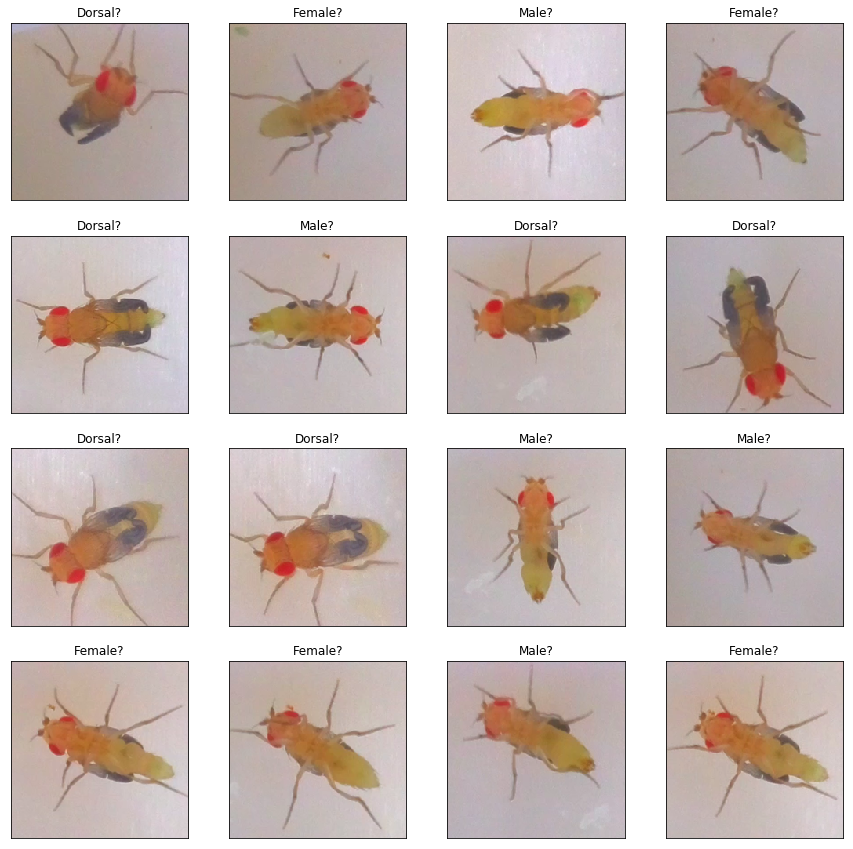

In [6]:
fig = plt.figure(figsize=(15,15))
titles = ['Male?', 'Female?', 'Dorsal?']
for i, (label, fly) in enumerate(zip(labels[:16], flies[:16])):
    fig.add_subplot(4,4, i+1) 
    plt.imshow(fly)
    plt.title(titles[int(label)])
    plt.xticks([])
    plt.yticks([])

## Normalization

In [7]:
flies  = flies.astype(np.float32)
flies /= 255 # pretty simple

## Split into training, validation, and test sets

In [8]:
f_train = 0.8 # Let's train on 80% and validate/test on 10% each
len_train = int(np.floor(len(flies) * f_train))
len_valid = (len(flies) - len_train) // 2
len_test  = len(flies) - len_train - len_valid
x_train = flies [:len_train]
y_train = labels[:len_train]
x_valid = flies [len_train: -len_test]
y_valid = labels[len_train: -len_test]
x_test  = flies [-len_test:]
y_test  = labels[-len_test:]
print('Training set samples  :', len(x_train), 'and labels:', len(y_train))
print('Validation set samples:', len(x_valid), ' and labels:', len(y_valid))
print('Test set samples      :', len(x_test) , ' and labels:', len(y_test))

Training set samples  : 2265 and labels: 2265
Validation set samples: 283  and labels: 283
Test set samples      : 284  and labels: 284


Check that the number of males and females in each set are roughly equal

In [9]:
def print_label_stats(lab, title):
    print('Percent ' + title + ' in... ')
    print('training set  : ' + str(sum(y_train==lab) / len(y_train) * 100) + '%')
    print('validation set: ' + str(sum(y_valid==lab) / len(y_valid) * 100) + '%')
    print('test set      : ' + str(sum(y_test ==lab) / len(y_test ) * 100) + '%' + '\n')

In [10]:
print_label_stats(0, 'male')
print_label_stats(1, 'female')
print_label_stats(2, 'dorsal')

Percent male in... 
training set  : 34.1721854305%
validation set: 28.2685512367%
test set      : 31.6901408451%

Percent female in... 
training set  : 32.7593818985%
validation set: 36.7491166078%
test set      : 34.5070422535%

Percent dorsal in... 
training set  : 33.0684326711%
validation set: 34.9823321555%
test set      : 33.8028169014%



## Build Network

In [11]:
w_init = 'glorot_normal' # Weights initialization
opt = Nadam(lr=0.0015, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.01)
model = Sequential()
model.add(MaxPooling2D(pool_size=(2, 2), input_shape=ishape))
model.add(Conv2D(8, (4, 4), padding='same', activation='relu', kernel_initializer=w_init))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, (3, 3), padding='same', activation='relu',kernel_initializer=w_init))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (2, 2), padding='same', activation='relu', kernel_initializer=w_init))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (2, 2), padding='same', activation='relu', kernel_initializer=w_init))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(16, activation='relu', kernel_initializer=w_init))
model.add(Dense(3, activation='softmax', kernel_initializer=w_init))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d_1 (MaxPooling2 (None, 113, 113, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 113, 113, 8)       392       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 16)        1168      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        2080      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
__________

## Train

In [12]:
best_model_path = 'models/vd_weights000.hdf5'
callbacks = [ModelCheckpoint(best_model_path)]
history = model.fit(x_train, np_utils.to_categorical(y_train), 
                    batch_size=32, 
                    epochs=40, 
                    verbose=1, 
                    validation_data=(x_valid, np_utils.to_categorical(y_valid)), 
                    callbacks=callbacks)

Train on 2265 samples, validate on 283 samples
Epoch 1/40
2265/2265 [==============================] - 30s 13ms/step - loss: 1.0993 - acc: 0.3448 - val_loss: 1.0967 - val_acc: 0.2968
Epoch 2/40
2265/2265 [==============================] - 34s 15ms/step - loss: 1.0769 - acc: 0.4243 - val_loss: 0.9952 - val_acc: 0.5866
Epoch 3/40
2265/2265 [==============================] - 27s 12ms/step - loss: 0.8387 - acc: 0.6508 - val_loss: 0.5874 - val_acc: 0.7951
Epoch 4/40
2265/2265 [==============================] - 31s 14ms/step - loss: 0.5332 - acc: 0.7982 - val_loss: 0.4038 - val_acc: 0.8763
Epoch 5/40
2265/2265 [==============================] - 29s 13ms/step - loss: 0.3277 - acc: 0.8857 - val_loss: 0.1777 - val_acc: 0.9435
Epoch 6/40
2265/2265 [==============================] - 26s 12ms/step - loss: 0.2116 - acc: 0.9272 - val_loss: 0.1534 - val_acc: 0.9505
Epoch 7/40
2265/2265 [==============================] - 27s 12ms/step - loss: 0.1738 - acc: 0.9426 - val_loss: 0.0967 - val_acc: 0.9717
E

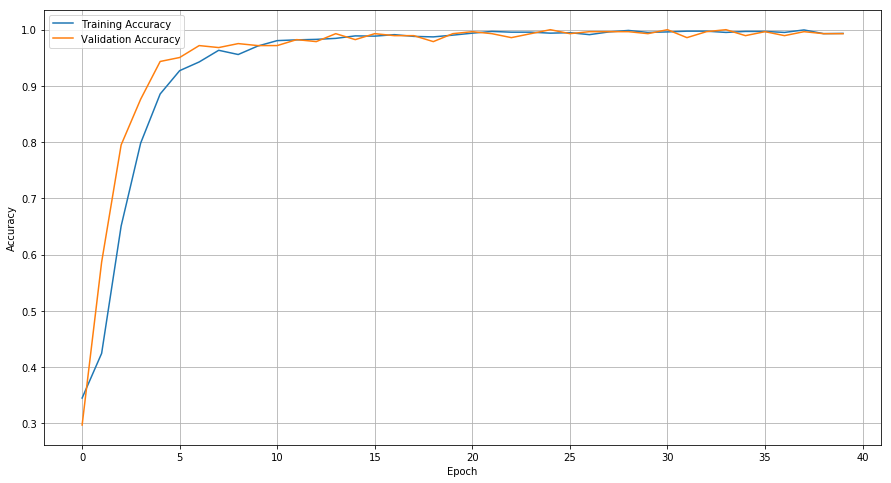

In [13]:
plt.figure(figsize=(15,8))
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.legend()
plt.grid(True)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

^Note the reason the validation accuracy is above the training accuracy is because the network has a dropout layer. The weights are only 'dropped out' in training, not in computing the validation (or test) accuracy.



## Load model with best validation accuracy and test!

In [14]:
model = load_model(best_model_path)

In [15]:
_, acc = model.evaluate(x_test, np_utils.to_categorical(y_test))

284/284 [==============================] - 2s 6ms/step


In [16]:
print('Test accuracy: ' + str(acc*100) + '%')

Test accuracy: 98.9436619718%
